# Dependencies

In [1]:
import numpy as np
import torch
from glob import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import util
from util import save_model, load_model, save_result, load_result
from model import VAE
from preprocess import ClipTransform, ReplaceNaN
from custom_dataset import CustomDataset
from torch.utils.data import DataLoader
from plots import plot_latent, reconstruct, plot_reconstructed, interpolate, interpolate_gif, decode_and_plot
from pymagdisc import config

%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [2]:
# initialise vae model
beta = 1.0
vae = VAE(image_channels=1, h_dim=256 * 1 * 1, z_dim=2, beta = beta, device=device)
vae = torch.compile(vae) # comment this line if loading a non-compiled model

In [3]:
# load weights
vae = load_model(vae, model_path='./my_model/beta1.0_epoch3000_batchsize32_lr0.001/model.pth', device=device)

# Dataset

In [4]:
root_dir = './data/MDISC/small_dataset/train/train_v2d_alpha_cubic_512x512/'
labels_path = root_dir+'train_labels.txt'

width = 512
mean = [-3.5877]
std=[1.3475]

# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              torch.log,
                              ClipTransform(min_value=-21), #-inf resulted from log 0
                              ReplaceNaN(constant=-21), # NaN resulted from log -ve values
                              transforms.Normalize(mean=mean, std=std), # mean and std determined in `preprocess.ipynb`
                             ])
dataset = CustomDataset(root_dir=root_dir, labels_path=labels_path, transform=transform)

## Plot latent vectors
Let’s plot the latent vector representations of a few batches of data.

In [5]:
batch_size = 1
shuffle = False
num_workers = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

array([<Axes: xlabel='lv1', ylabel='lv2'>,
       <Axes: xlabel='lv1', ylabel='lv2'>,
       <Axes: xlabel='rmp', ylabel='Kh'>], dtype=object)

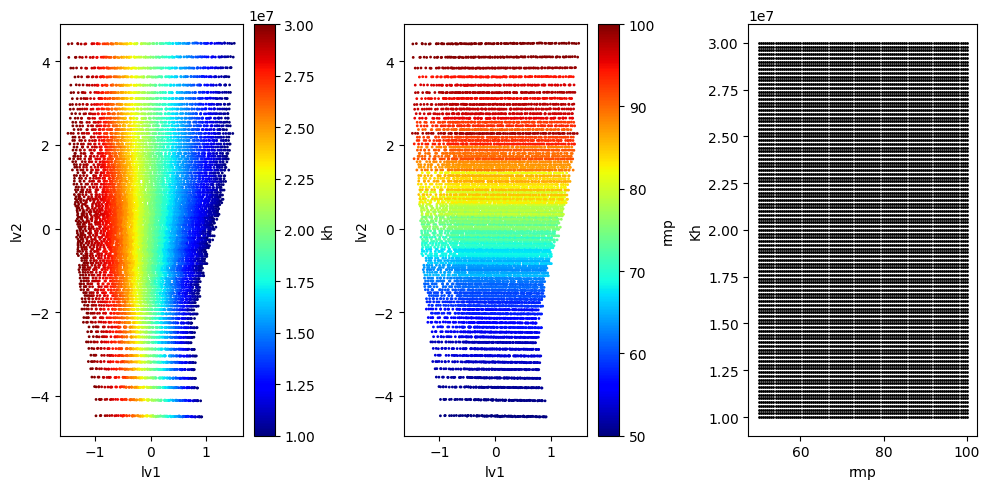

In [6]:
plot_latent(vae.eval(), dataloader, output="./output/beta1.0_epoch3000_batchsize32_lr0.001/latent_vectors_lowest_loss.jpg")

Ideally, we would like to see an arrangement of colour in the latent space (panels 1 and 2), following the same arrangement as in the 3rd panel. This would indicate that the latent variables really correspond to the parameters 'kh' and 'rmp'.

## Decode latent vector

CPU times: user 53 ms, sys: 15.1 ms, total: 68.1 ms
Wall time: 239 ms


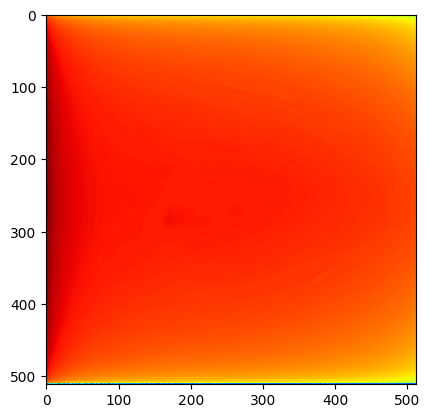

In [20]:
%%time
# how long does it take to decode latent vector to output (GPU)
x_hat = decode_and_plot(model=vae.eval(), z=torch.tensor([ [[2.5,-3]] ]).to(device).float(), width=512, plot=True)

CPU times: user 382 ms, sys: 66.8 ms, total: 448 ms
Wall time: 1.34 s


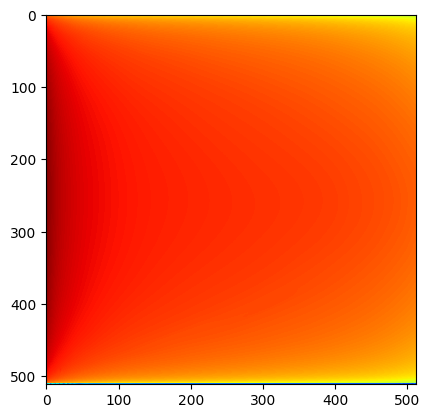

In [46]:
%%time
# how long does it take to decode latent vector to output (CPU)
x_hat = decode_and_plot(model=vae.eval(), z=torch.tensor([ [[2.5,-3]] ]).to(device).float(), width=512, plot=True)

We will need to have a function to map the latent vector (lv1, lv2) back to the exact (Kh, rmp). If the function is not linear, another neural network could be trained to learn this mapping. 

## Visualizing reconstructions

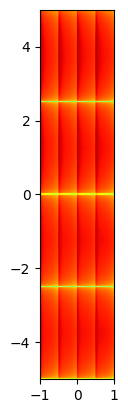

In [22]:
plot_reconstructed(vae, width=512, z0=(-1, 1), z1=(-5, 5), n_img=4)

In [7]:
# load a sample from the dataloader
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    break

# reconstruct sample
x_hat = reconstruct(vae.eval(), x, width)


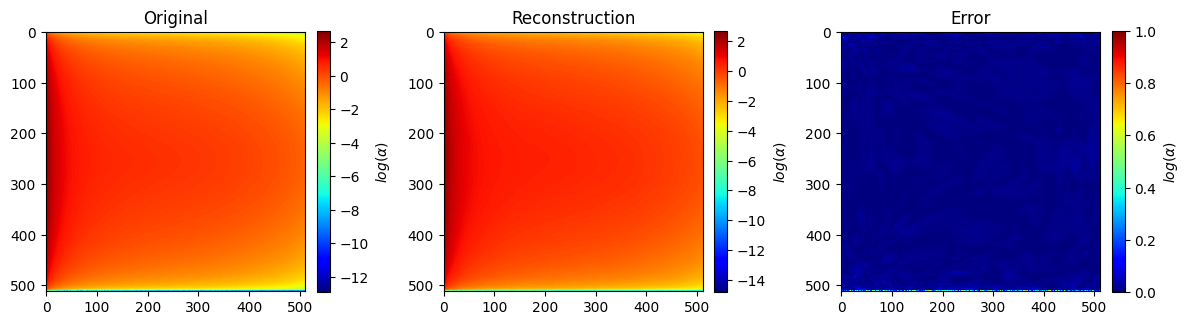

In [24]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
x_orig = x[0].cpu().detach().numpy().squeeze()
err = np.sqrt((x_orig-x_hat)**2)
s1 = ax[0].imshow(x_orig, cmap="jet")
s2 = ax[1].imshow(x_hat, cmap="jet")
s3 = ax[2].imshow(err, cmap='jet', vmin=0, vmax=1)
ax[0].set_title('Original')
ax[1].set_title('Reconstruction')
ax[2].set_title('Error')
plt.colorbar(s1, label=r'$log(\alpha)$', ax=ax[0], fraction=0.046, pad=0.04);
plt.colorbar(s2, label=r'$log(\alpha)$', ax=ax[1], fraction=0.046, pad=0.04);
plt.colorbar(s3, label=r'$log(\alpha)$', ax=ax[2], fraction=0.046, pad=0.04);
plt.tight_layout()

## Visualizing interpolations

In [25]:
batch_size = 128
shuffle = False
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

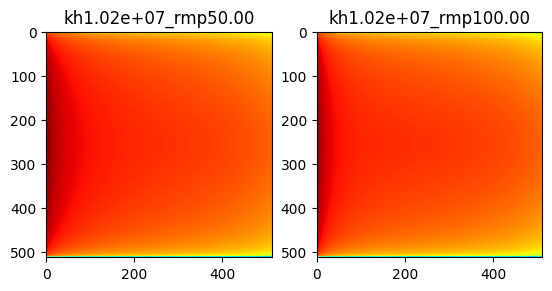

In [26]:
for x,y in dataloader:
    y = np.array(y)
    # find sample corresponding to label y
    x_1 = x[y == 'kh1.02e+07_rmp50.00'][0].unsqueeze(dim=1).to(device).float() 
    x_2 = x[y == 'kh1.02e+07_rmp100.00'][0].unsqueeze(dim=1).to(device).float()
    
    # plot interpolation
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x_1.cpu().detach().numpy().squeeze(), cmap='jet')
    ax[1].imshow(x_2.cpu().detach().numpy().squeeze(), cmap='jet')
    ax[0].set_title('kh1.02e+07_rmp50.00')
    ax[1].set_title('kh1.02e+07_rmp100.00')
    break

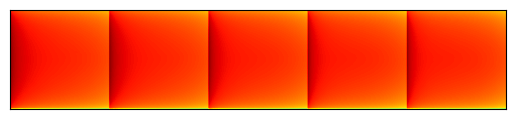

In [27]:
interpolate(vae.eval(), x_1, x_2, width, n_img=5)

In [176]:
interpolate_gif(vae, width, "vae", x_1, x_2)

## Convert reconstruction to `.mat`

In [7]:
import scipy.io as sio

# load a sample from the dataloader
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = y[0]
    print(y)
    break

# reconstruct sample
x_hat = reconstruct(vae.eval(), x, width)

# get resampled coordinates
filename = f"{config.PATH_TO_DATA}jup_mdisc_{y}_nr601_nmu601.pkl"
MD = util.load_result(filename)
width = height = 512
xi, yi, zi = util.resample_irreg2regGrid(x=MD["c2d"]["r"],
                        y=MD["c2d"]["mu"],
                        z=MD["v2d"]["alpha"],
                        xi=np.linspace(np.min(MD["c2d"]["r"]), np.max(MD["c2d"]["r"]), width),
                        yi=np.linspace(np.min(MD["c2d"]["mu"]), np.max(MD["c2d"]["mu"]), height),
                        interp_method='cubic')

# # Convert the Python array to a MATLAB struct
matlab_struct = {'label':f'jup_mdisc_{y}_nr601_nmu601.pkl', 'alpha':zi, 'alpha_pred':np.exp(x_hat*std[0]+mean[0]), 'r':xi, 'mu':yi}


kh1.02e+07_rmp100.00


In [8]:
(np.abs(np.exp(x_hat*std[0]+mean[0]) - zi) < 1e-6).sum()

2460

In [9]:
# Specify the filename to save as
matlab_filename = f'./output/beta1.0_epoch3000_batchsize32_lr0.001/alpha_{y}.mat'

# Save the MATLAB struct as a .mat file
sio.savemat(matlab_filename, matlab_struct)

In [93]:
matlab_struct

{'label': 'jup_mdisc_kh1.02e+07_rmp100.00_nr601_nmu601.pkl',
 'alpha': array([[ 0.00000000e+00, -2.10244847e-05, -2.09262320e-05, ...,
          1.82194717e-08,  1.89647519e-08,  0.00000000e+00],
        [ 7.81340268e-03,  6.54998470e-03,  5.61423856e-03, ...,
          4.29034064e-05,  4.21000484e-05,  4.12264540e-05],
        [ 1.55956575e-02,  1.30725513e-02,  1.12382623e-02, ...,
          8.62410973e-05,  8.45718071e-05,  8.28455073e-05],
        ...,
        [ 1.55956577e-02,  1.30536994e-02,  1.12451664e-02, ...,
          8.62935920e-05,  8.45570852e-05,  8.28455065e-05],
        [ 7.81340271e-03,  6.56878736e-03,  5.60661265e-03, ...,
          4.29336812e-05,  4.20687048e-05,  4.12264542e-05],
        [ 0.00000000e+00, -1.02445220e-05, -3.35816133e-05, ...,
         -1.88809500e-08,  2.13865910e-08,  0.00000000e+00]]),
 'alpha_pred': array([[1.0913245e-09, 2.4911626e-09, 3.3893365e-08, ..., 5.8890759e-09,
         7.8044522e-09, 6.6373462e-10],
        [7.5069801e-03, 6.56199

In [ ]:
# calculate error of the reconstruction
err = np.sqrt((np.log(matlab_struct["alpha"])-np.log(matlab_struct["alpha_pred"]))**2)

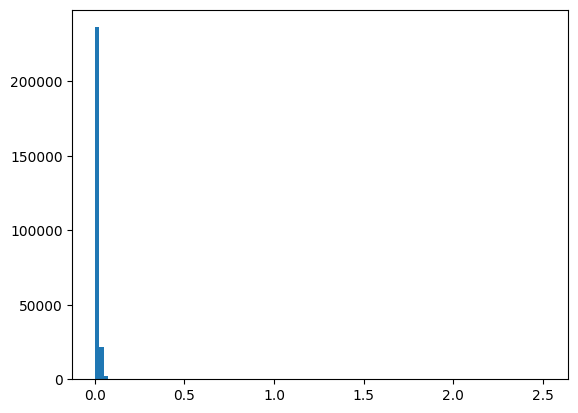

In [32]:
err[err==float('+inf')] = 0
plt.hist(err.flatten(), bins=100);

/tmp/ipykernel_77443/2188771189.py:8: RuntimeWarning: divide by zero encountered in log
  c=np.log(matlab_struct["alpha"]),
/tmp/ipykernel_77443/2188771189.py:8: RuntimeWarning: invalid value encountered in log
  c=np.log(matlab_struct["alpha"]),
/tmp/ipykernel_77443/2188771189.py:32: RuntimeWarning: divide by zero encountered in log
  np.log(err),


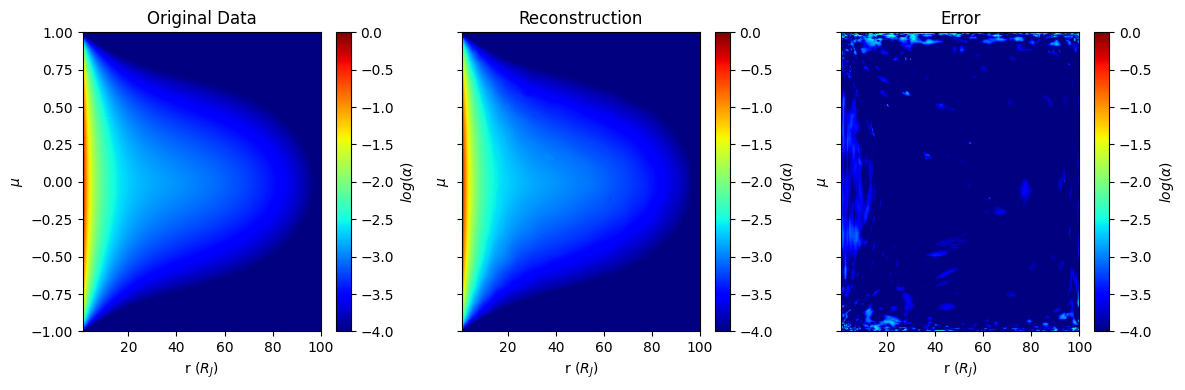

In [33]:
# Plot the original and resampled data
output = f'./output/beta1.0_epoch3000_batchsize32_lr0.001/alpha_orig_recon_{y}.jpg'

fig, ax = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

s = ax[0].scatter(matlab_struct["r"],
            matlab_struct["mu"],
            c=np.log(matlab_struct["alpha"]),
            s=1,
        vmin=-4,
        vmax=0,
        cmap="jet",)
ax[0].set_xlabel('r ($R_J$)')
ax[0].set_ylabel(r'$\mu$')
ax[0].set_title('Original Data')
plt.colorbar(s, label=r'$log(\alpha)$', ax=ax[0])

pc = ax[1].pcolormesh(matlab_struct["r"],
            matlab_struct["mu"],
            np.log(matlab_struct["alpha_pred"]),
        shading="gouraud",
        vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_xlabel('r ($R_J$)')
ax[1].set_ylabel(r'$\mu$')
ax[1].set_title('Reconstruction')
plt.colorbar(pc, label=r'$log(\alpha)$', ax=ax[1])

pc = ax[2].pcolormesh(matlab_struct["r"],
            matlab_struct["mu"],
            np.log(err),
        shading="gouraud",
        vmin=-4,
        vmax=0,
        cmap="jet")
ax[2].set_xlabel('r ($R_J$)')
ax[2].set_ylabel(r'$\mu$')
ax[2].set_title('Error')
plt.colorbar(pc, label=r'$log(\alpha)$', ax=ax[2])
plt.tight_layout()

if output:
    plt.savefig(output, dpi=300)
    
plt.show()